In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cycler import cycler
from datetime import date

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('/home/hosilva/tools/mplstyle/timesnromanstyle.mplstyle')

from __future__ import unicode_literals

In [2]:
import lal, lalsimulation

In [3]:
from tools import find_kde
from tools import combined_posterior

In [24]:
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.optimize import brentq

In [44]:
def find_threshold(mass, thr_coef=1/2.):
    m_in_km = np.median(mass) * Msun_to_km
    return thr_coef * m_in_km

def find_cdf_at_threshold(m, l, lmax=68):
    # Take the posterior distribution and from seaborn's KDE extract
    # the points from the curve.
    l_tmp, pdf_tmp = find_kde(l)
    
    # Create an interpolating function for the posterior
    pdf_l_tmp = ius(l_tmp, pdf_tmp)
    
    # Calculate CDF at sample values of l by integrating the posterior
    l_vals = np.arange(0, lmax + 1, 1)
    cdf_tmp = [pdf_l_tmp.integral(0, lmax) for lmax in l_vals]
    cdf_l_tmp = ius(l_vals, cdf_tmp)
    
    # Find where it is 90%
    def find_x90(x): return cdf_l_tmp(x) - 0.90
    def find_x68(x): return cdf_l_tmp(x) - 0.68
    x90 = brentq(find_x90, 0, max(l_vals))
    x68 = brentq(find_x68, 0, max(l_vals))
    print(x68, x90, find_threshold(m, 1/2.))
    
    # Set a number of epsilon and calculate the thresholds values
    epsilon_vals  = np.arange(0, 1.0 + 0.01, 0.01)
    m_thresholds  = np.array([find_threshold(m, eps) for eps in epsilon_vals]) # in km

    # Finally, calculate the cdf at the threshold values
    cdf_at_m_thresholds = np.array([cdf_l_tmp(m) for m in m_thresholds])
    
    return epsilon_vals, cdf_at_m_thresholds

In [4]:
Msun_to_km = 1.476

In [60]:
# Load data

data_GW150914_edgb = np.genfromtxt("/home/hosilva/parspec/pe/GW150914/parspec_runs/p4_l_df0_dtau0_GB_220227/cbcBayes/posterior_samples.dat", names=True, dtype=None)
data_GW200129_edgb = np.genfromtxt("/home/abhirup.ghosh/Documents/Work/spinqnm/runs/parspec/GW200129/p4_l_df0_dtau0_GB/cbcBayes/posterior_samples.dat", names=True, dtype=None)

In [61]:
GW150914_edgb_l   = data_GW150914_edgb['alphangr']
GW150914_edgb_m2  = data_GW150914_edgb['m2_source']
GW150914_edgb_mf  = data_GW150914_edgb['mf_source_evol']

GW200129_edgb_l   = data_GW200129_edgb['alphangr']
GW200129_edgb_m2  = data_GW200129_edgb['m2_source']
GW200129_edgb_mf  = data_GW200129_edgb['mf_source_evol']

print(len(GW150914_edgb_l), len(GW200129_edgb_l))

42796 29353


/.auto/home/hosilva/python38_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


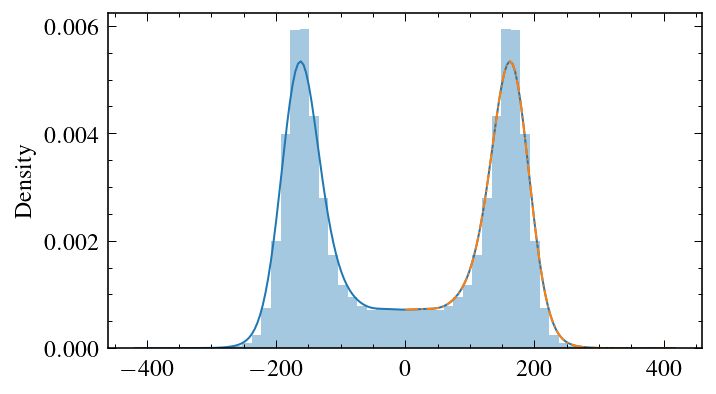

In [87]:
GW150914_edgb_pdf_l_x, GW150914_edgb_pdf_l_y = find_kde(GW150914_edgb_l)

/.auto/home/hosilva/python38_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


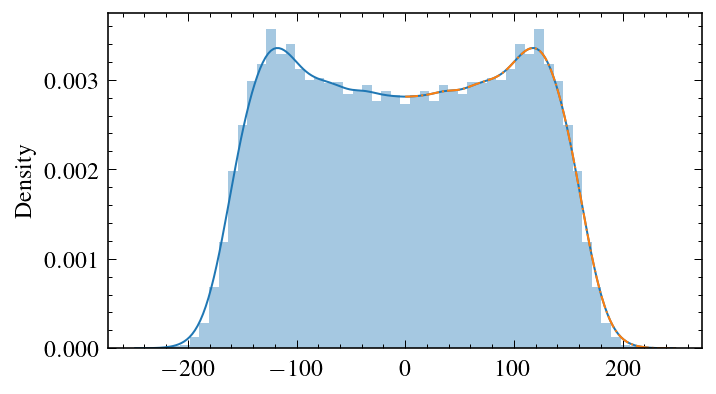

In [88]:
GW200129_edgb_pdf_l_x, GW200129_edgb_pdf_l_y = find_kde(GW200129_edgb_l)

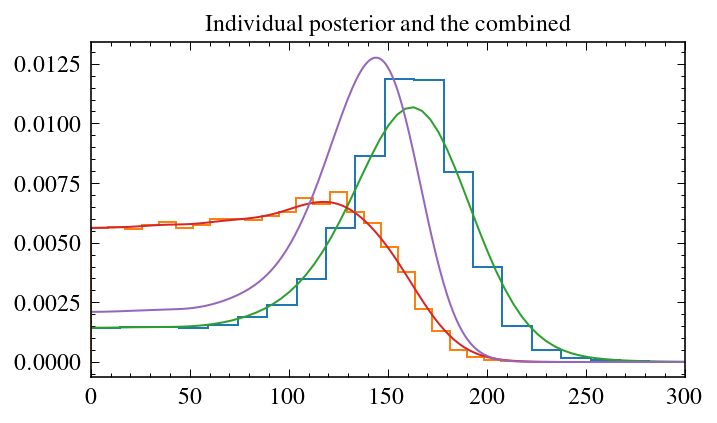

In [108]:
plt.hist(GW150914_edgb_l, density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
plt.hist(GW200129_edgb_l, density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
plt.plot(GW150914_edgb_pdf_l_x, GW150914_edgb_pdf_l_y)
plt.plot(GW200129_edgb_pdf_l_x, GW200129_edgb_pdf_l_y)

GW150914_edgb_pdf_interp = ius(GW150914_edgb_pdf_l_x, GW150914_edgb_pdf_l_y)
GW200129_edgb_pdf_interp = ius(GW200129_edgb_pdf_l_x, GW200129_edgb_pdf_l_y)

# Now we multiply them:
edgb_l_vals = np.linspace(0, 418, num=419)

edgb_combined_l_vals = [GW150914_edgb_pdf_interp(x) * GW200129_edgb_pdf_interp(x) for x in edgb_l_vals]

edgb_combined_pdf = ius(edgb_l_vals, edgb_combined_l_vals)

edgb_combined_pdf_normalized_vals = np.array(edgb_combined_l_vals) / edgb_combined_pdf.integral(0, 418)

plt.title('Individual posterior and the combined')
plt.plot(edgb_l_vals, edgb_combined_pdf_normalized_vals)

plt.xlim(0, 300);

/local/tmp/hosilva/ipykernel_2293601/915265335.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


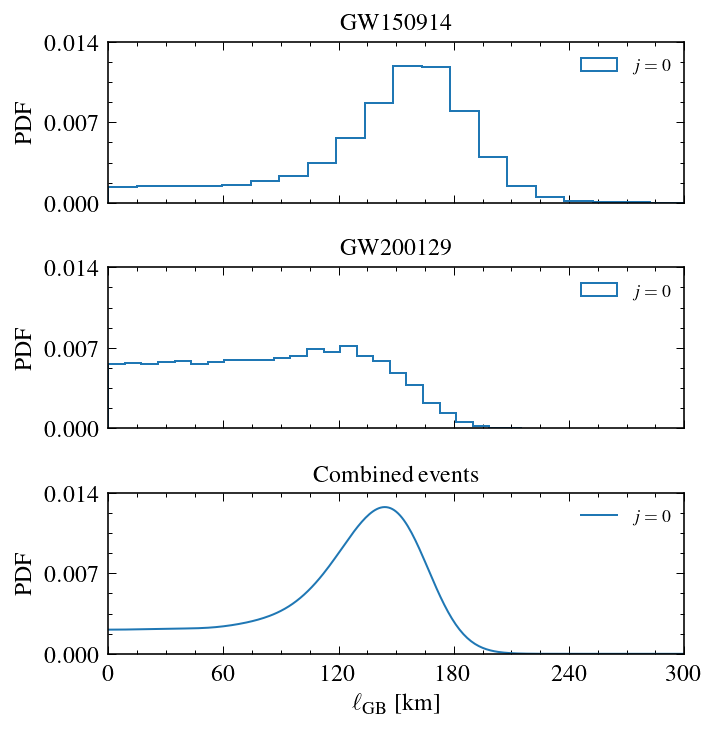

In [104]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B'],
     ['C', 'C', 'C']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'left':0.15, 'hspace': 0.4, 'wspace': 0.6, 'bottom':0.1})

for k in ('A', 'B', 'C'):
    axes[k].set_xlim(0, 300)
    axes[k].xaxis.set_ticks(np.arange(0, 300+60, 60))
    
for k in ('A', 'B'):
    axes[k].set_xticklabels([]);
    
axes['C'].set_xlabel(r'$\ell_{\rm GB}$ [km]');

axes['A'].hist(GW150914_edgb_l, density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
# axes['A'].hist(GW150914_spin_edgb_l, density=True, histtype='step', bins=25, ls='--', label=r"$j=0,1$");
axes['A'].set_ylim(0, 0.014);
axes['A'].yaxis.set_ticks([0, 0.007, 0.014]);
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper right', fontsize=9);
axes['A'].set_ylabel("PDF");

axes['B'].hist(GW200129_edgb_l,      density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
# axes['B'].hist(GW200129_spin_edgb_l, density=True, histtype='step', bins=25, ls='--', label=r"$j=0,1$");
axes['B'].set_ylim(0, 0.014);
axes['B'].yaxis.set_ticks([0, 0.007, 0.014]);
axes['B'].set_title("GW200129");
axes['B'].legend(loc='upper right', fontsize=9);
axes['B'].set_ylabel("PDF");

axes['C'].set_title("Combined events");
# axes['C'].xaxis.set_ticks(np.arange(0, 60+10, 10))
axes['C'].set_ylabel("PDF");
axes['C'].plot(edgb_l_vals, edgb_combined_pdf_normalized_vals, '-',  label=r"$j=0$")
# axes['C'].plot(dcs_l_spin_combined, y_dcs_l_spin_combined, '--', label=r"$j=0,1$")
axes['C'].legend(loc='upper right', fontsize=9);
axes['C'].set_ylim(0, 0.014);
axes['C'].yaxis.set_ticks([0, 0.007, 0.014]);

plt.tight_layout()
plt.savefig('fig_output/edgb_posteriors_combined.pdf')

/.auto/home/hosilva/python38_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


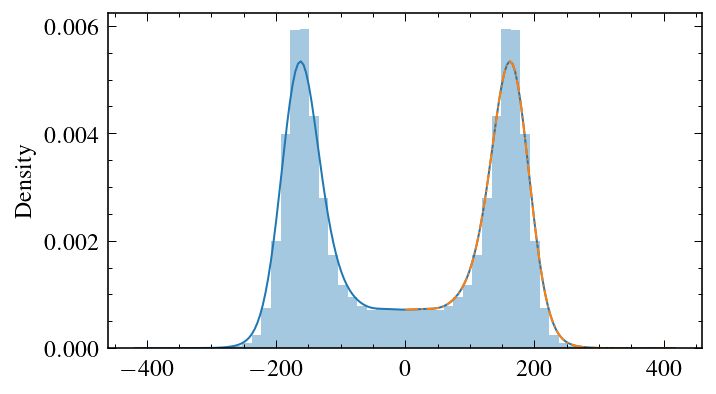

In [34]:
GW150914_edgb_pdf_x, GW150914_edgb_pdf_y = find_kde(GW150914_edgb_l)

In [45]:
print(max(GW150914_edgb_pdf_x))
# print(np.arange(0, 418 + 1, 1))

418.00432261130646


197.15998001855883 197.15998001855883 22.081519018252397 45.84189029871594


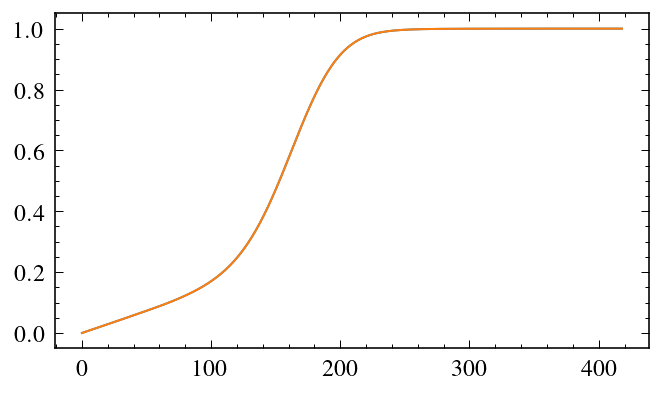

In [49]:
GW150914_edgb_pdf_interp = ius(GW150914_edgb_pdf_x, GW150914_edgb_pdf_y)

l_tmp = np.arange(0, 418 + 1, 1)

GW150914_edgb_cdf_y = [GW150914_edgb_pdf_interp.integral(0, lnow) for lnow in l_tmp]

GW150914_edgb_cdf_interp = ius(l_tmp, GW150914_edgb_cdf_y)

plt.plot(l_tmp, GW150914_edgb_cdf_y)
plt.plot(l_tmp, GW150914_edgb_cdf_interp(l_tmp))

def find_x90(x): return GW150914_edgb_cdf_interp(x) - 0.90
def find_x68(x): return GW150914_edgb_cdf_interp(x) - 0.68

GW150914_edgb_x90 = brentq(find_x90, 0, max(l_tmp))
GW150914_edgb_x68 = brentq(find_x90, 0, max(l_tmp))
print(GW150914_edgb_x68, GW150914_edgb_x90, find_threshold(GW150914_edgb_m2, 1/2.), find_threshold(GW150914_edgb_mf, 1/2.))
    
# plt.plot(l_tmp, GW150914_edgb_pdf_interp(l_tmp))
# plt.hist(GW150914_edgb_l, density=True)

/.auto/home/hosilva/python38_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


169.9293117646652 197.15998001855883 45.84189029871594


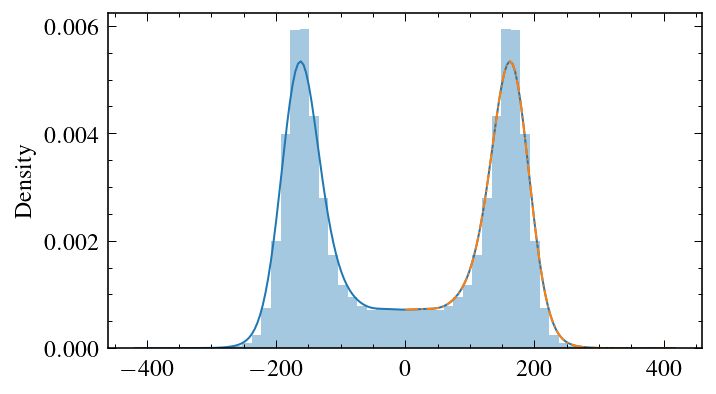

In [55]:
eps_val, GW150914_mf = find_cdf_at_threshold(GW150914_edgb_mf, GW150914_edgb_l, 418);

/.auto/home/hosilva/python38_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


169.9293117646652 197.15998001855883 22.081519018252397


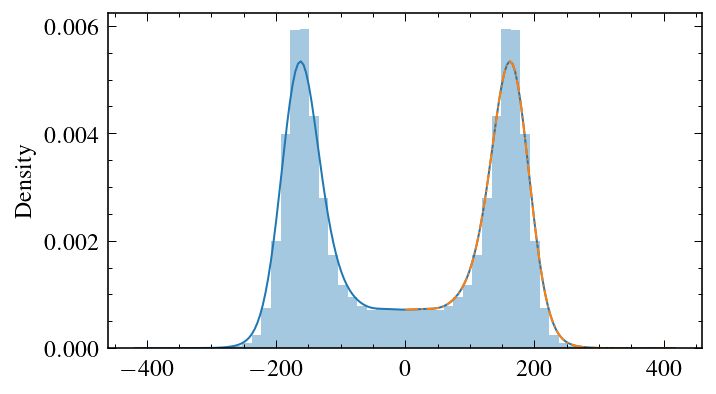

In [56]:
_, GW150914_m2 = find_cdf_at_threshold(GW150914_edgb_m2, GW150914_edgb_l, 418)

In [66]:
GW200129_edgb_l.max()

215.70896199623974

/.auto/home/hosilva/python38_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


114.41854803027108 150.39955805075553 43.86453770391392


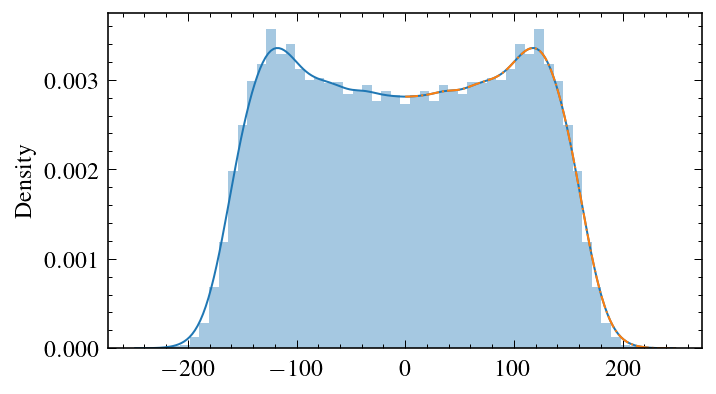

In [67]:
_, GW200129_mf = find_cdf_at_threshold(GW200129_edgb_mf, GW200129_edgb_l, 418);

/.auto/home/hosilva/python38_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


114.41854803027108 150.39955805075553 21.35905928669088


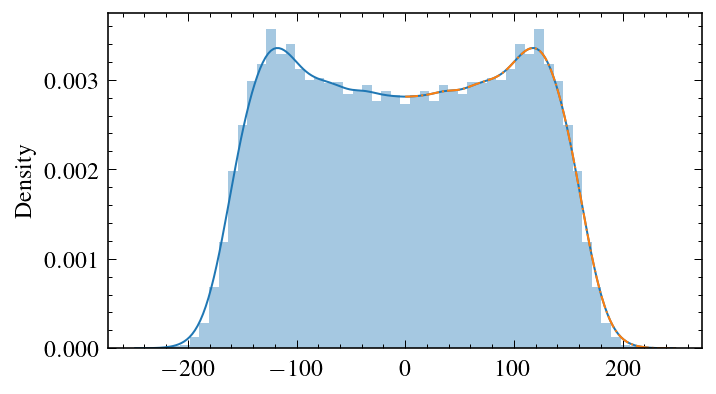

In [68]:
_, GW200129_m2 = find_cdf_at_threshold(GW200129_edgb_m2, GW200129_edgb_l, 418)

/local/tmp/hosilva/ipykernel_2293601/2175090952.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


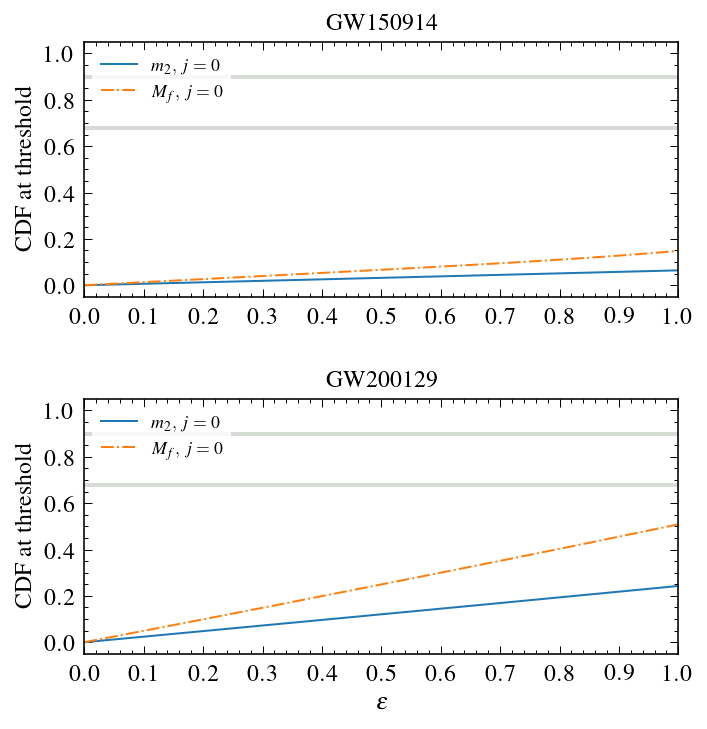

In [73]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.5, 'bottom': 0.1})
plt.tight_layout()

for k in ('A', 'B'):
    axes[k].set_xlim(0, 1)
    axes[k].set_ylim(-0.05, 1.05)
    axes[k].xaxis.set_ticks(np.arange(0, 1 + 0.1, 0.1))
    axes[k].axhline(0.90, color='xkcd:light gray', lw=2)
    axes[k].axhline(0.68, color='xkcd:light gray', lw=2)

# -------
# Panel A
# -------
axes['A'].plot(eps_val, GW150914_m2,      'C0-',  label=r"$m_{2}, \, j=0$")
# axes['A'].plot(eps_val, GW150914_m2_spin, 'C0--', label=r"$m_{2}, \, j=0,1$")
axes['A'].plot(eps_val, GW150914_mf,      'C1-.', label=r"$M_{f}, \, j=0$")
# axes['A'].plot(eps_val, GW150914_mf_spin, 'C1:',  label=r"$M_{f}, \, j=0,1$")
axes['A'].set_ylabel('CDF at threshold')
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper left', frameon=True, fontsize=9, facecolor='white', edgecolor='white');
axes['A'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

# -------
# Panel B
# -------
axes['B'].plot(eps_val, GW200129_m2,      'C0-',  label=r"$m_{2}, \, j=0$")
# axes['B'].plot(eps_val, GW200129_m2_spin, 'C0--', label=r"$m_{2}, \, j=0,1$")
axes['B'].plot(eps_val, GW200129_mf,      'C1-.', label=r"$M_{f}, \, j=0$")
# axes['B'].plot(eps_val, GW200129_mf_spin, 'C1:',  label=r"$M_{f}, \, j=0,1$")
axes['B'].set_ylabel('CDF at threshold')
axes['B'].set_xlabel(r'$\varepsilon$')
axes['B'].set_title("GW200129");
axes['B'].legend(loc='upper left', frameon=True, fontsize=9, facecolor='white', edgecolor='white');
axes['B'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

plt.savefig('fig_output/edgb_cdf_varying_threshold.pdf')